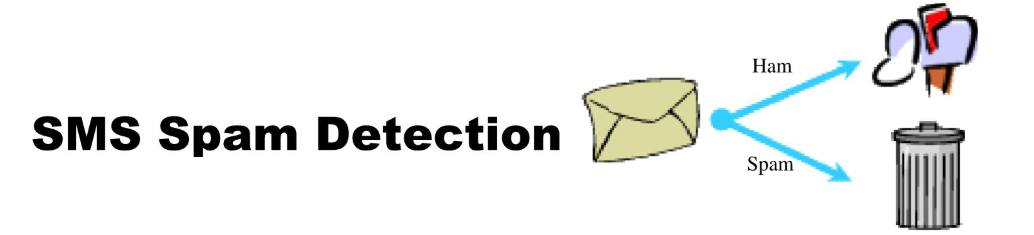

**Project Aim:**

Our project focuses on developing an SMS spam detection classifier with a primary objective of achieving a high recall rate for spam (our positive class). While emphasizing high recall, we also aim to balance precision to minimize false positives(misclassified ham messages) and ensure accurate classification of legitimate messages.

We are committed to selecting a classifier that effectively protects users against spam and its associated threats, including malware, phishing, and scams, while maintaining clean and organized inboxes.





# 1. Load and Understand Data

In [1]:
# install optuna
!pip install optuna

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud  # Generates world cloud viz from text data


from scipy.stats import kurtosis, skew

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, recall_score, f1_score, confusion_matrix
import optuna

In [3]:
# Download a pre-trained model specifically designed for word,sentence tokenization
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
data = pd.read_csv('/content/drive/MyDrive/Portfolio Projects/Machine Learning/Binary Classification/Spam Detection/spam.csv', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          3500 non-null   object
 1   v2          3500 non-null   object
 2   Unnamed: 2  28 non-null     object
 3   Unnamed: 3  7 non-null      object
 4   Unnamed: 4  3 non-null      object
dtypes: object(5)
memory usage: 136.8+ KB


In [7]:
# Nr. of observations
print(f'The data set holds {len(data)} records.')

The data set holds 3500 records.


# 2. Data Cleaning

In [8]:
# Check and Drop duplicated rows
d = data.duplicated().sum()
data.drop_duplicates(inplace=True)
print(f'{d} duplicates found and removed.')

198 duplicates found and removed.


In [9]:
# Check for missing values
data.isnull().sum()

,0
v1,0
v2,0
Unnamed: 2,3276
Unnamed: 3,3296
Unnamed: 4,3299


In [10]:
# Drop unneccesary columns
data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)

In [11]:
# Rename columns to more meaningful names
data.columns = ['label', 'message']

In [12]:
df = data.copy() # make a copy of cleaned dataset

# 3. EDA : Cleaned Data

## 3.1 Numerical Features

In [13]:
# Define a function to classify skewness and kurtosis of numerical distributions
def classify_distribution(variable):
  '''
    Classifies the skewness and kurtosis of a given dataset.

    Parameters:
        variable:
                 It should contain numeric values.

    Returns:
        tuple: A tuple containing:
            - skew_type (str): A description of the skewness of the distribution:
                - 'Symmetrical': The distribution is approximately symmetrical.
                - 'Negatively Skewed': The distribution is pulled to the left by extreme low values.
                - 'Positively Skewed': The distribution is pulled to the right by extreme high values.
            - kurtosis_type (str): A description of the kurtosis of the distribution:
                - 'Platykurtic': The distribution has thinner tails and a flatter peak, indicating fewer outliers.
                - 'Mesokurtic': The distribution is similar to a normal distribution, with moderate tails and a typical number of outliers.
                - 'Leptokurtic': The distribution has fatter tails and a sharper peak, indicating more outliers.

    Description:
        - Skewness measures the asymmetry of the distribution:
            - Symmetrical distributions have a skewness close to 0.
            - Positive skewness indicates a tail on the right (high values), while Negative skewness indicates a tail on the left (low values).
        - Kurtosis measures the "tailedness" of the distribution:
            - Platykurtic distributions are flatter than normal with fewer extreme outliers.
            - Mesokurtic distributions resemble a normal distribution with typical outliers.
            - Leptokurtic distributions have sharper peaks and fatter tails, indicating more extreme values.
  '''

  s = skew(variable)
  k = kurtosis(variable, fisher=False)
  if abs(s) < 1:
    skew_type = 'Symmetrical.'
  elif s < -1:
    skew_type = 'Negatively Skewed.'
  else:
     skew_type ='Positively Skewed.'
  if k < 3:
    kurtosis_type = 'Platykurtic.'
  elif k == 3:
    kurtosis_type = 'Mesokurtic.'
  else:
    kurtosis_type = 'Leptokurtic.'
  return skew_type, kurtosis_type

In [14]:
def plot_histograms(display_name, col_name):

  '''
    Plots histograms for numeric distributions in 'ham' and 'spam' messages
    and analyzes their skewness and kurtosis.

    Parameters:
        display_name (str): A descriptive name for the column, used in plot titles and print statements.
        col_name (str): The column name containing the numeric data to analyze.

    Returns:
        None: Displays histograms and prints skewness and kurtosis analysis.
  '''

  ham_data = df[df['label'] == 'ham'][col_name]
  spam_data = df[df['label'] == 'spam'][col_name]

  # Create histograms
  fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # Create a figure and 2 subplots

  ## Histogram for 'ham'
  axes[0].hist(ham_data, bins=50, alpha=0.7, label='ham', color='#4Cbb17')
  axes[0].set_title(f'Ham {display_name} Distribution')
  axes[0].legend()

  ## Histogram for 'spam'
  axes[1].hist(spam_data, bins=50, alpha=0.5, label='spam', color='#D21404')
  axes[1].set_title(f'Spam {display_name} Distribution')
  axes[1].legend()

  plt.tight_layout()
  plt.show()

  # Classify skewness and kurtosis types
  skew_type, kurtosis_type = classify_distribution(ham_data)
  print(f'Ham {display_name} Distribution: Skewness: {skew_type} Kurtosis: {kurtosis_type}')
  skew_type, kurtosis_type = classify_distribution(spam_data)
  print(f'Spam {display_name} Distribution: Skewness: {skew_type} Kurtosis: {kurtosis_type}')


### 3.1.1 Comparative Analysis

#### Character Count : Ham vs. Spam

<font color = "4d5aa6">Character count is the length of the message which includes spaces and punctuation.</font>

In [15]:
# Create a new feature that captures character count of the message
df['character_count'] = df['message'].apply(len)

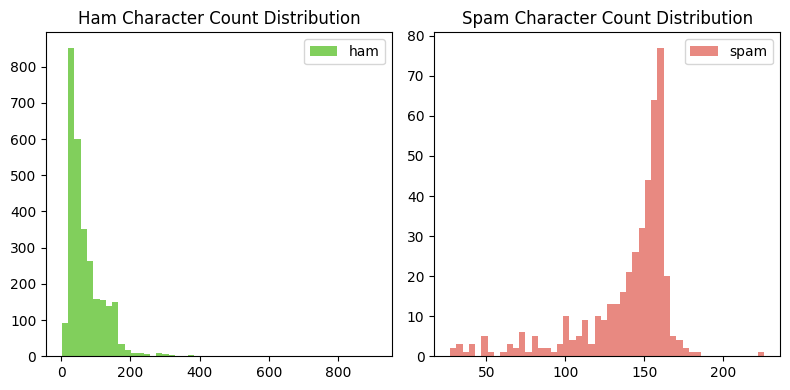

Ham Character Count Distribution: Skewness: Positively Skewed. Kurtosis: Leptokurtic.
Spam Character Count Distribution: Skewness: Negatively Skewed. Kurtosis: Leptokurtic.


In [16]:
# Create histograms to visualize the distribution of character counts for the target classes
plot_histograms('Character Count', 'character_count')

##### 🔍 Observations

Ham messages  tend to have a wider range of lengths, with most messages being relatively short but there are a significant number of very long messages.Spam messages tend to have a more consistent length, clustering around a central value with fewer very short messages.

#### Word Count : Ham vs. Spam

<font color = "4d5aa6">Word count measures the number of individual words within the message.</font>

In [17]:
# Create a new feature that captures word count of the message
df['word_count'] = df['message'].apply(lambda x: len(word_tokenize(x)))
#df.head()

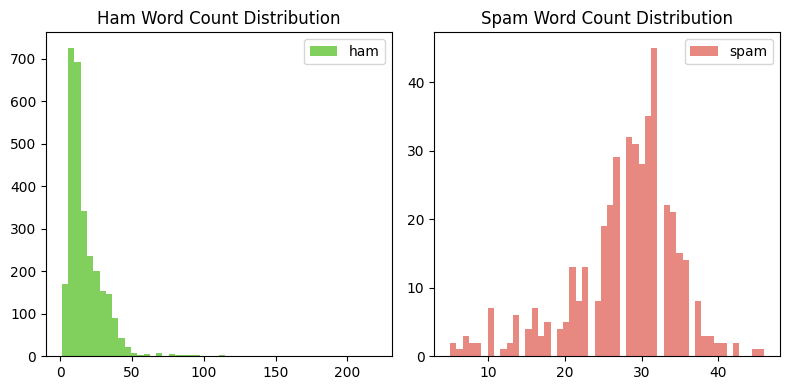

Ham Word Count Distribution: Skewness: Positively Skewed. Kurtosis: Leptokurtic.
Spam Word Count Distribution: Skewness: Symmetrical. Kurtosis: Leptokurtic.


In [18]:
# Create histograms to visualize the distribution of character counts for the target classes
plot_histograms('Word Count', 'word_count')

##### 🔍 Observations

Ham messages are generally shorter yet vary more in length, while spam messages are typically longer and consistent. This difference in word count indicates that it is a valuable feature for helping a model better identify and accurately classify spam messages.

Word count offers a clearer view of a message's content by reflecting the actual number of words, making it a key factor in text classification. In contrast, message length includes all characters, which may not accurately represent content quality as it includes irrelvant information and noise. Hence, word count is a more reliable feature for distinguishing between ham and spam messages, enhancing classification accuracy.

#### Sentence Count: Ham vs. Spam

<font color = "4d5aa6">Sentence count measures the number of sentences within the message.</font>

In [19]:
# Create a new feature that captures sentence count of the message
df['sentence_count'] = df['message'].apply(lambda x: len(sent_tokenize(x)))
#df.head()

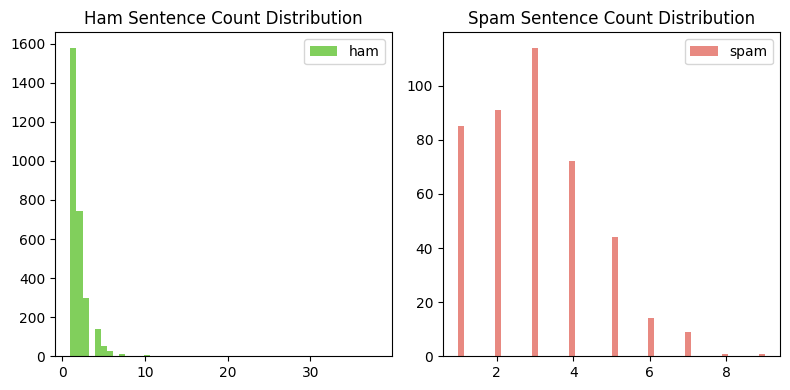

Ham Sentence Count Distribution: Skewness: Positively Skewed. Kurtosis: Leptokurtic.
Spam Sentence Count Distribution: Skewness: Symmetrical. Kurtosis: Leptokurtic.


In [20]:
# Create histograms to visualize the distribution of sentence counts for the target classes
plot_histograms('Sentence Count', 'sentence_count')

##### 🔍 Observations

Ham messages tend to have lower sentence counts, while spam messages exhibit a more diverse range of sentence lengths.

Sentence count can provide valuable input for classification:
* Very low sentence counts (1–3) strongly indicate ham.
* Moderate counts (4–8) could lean toward spam, but this is not definitive.
* Very high counts (>10) may indicate outliers, which require additional features for robust classification; it is often beneficial to combine it with other features

### 3.1.2 Correlation Analysis

In [21]:
df_corr = df.copy()

In [22]:
#  Maps the 'label' column in the DataFrame 'df_corr' to numerical values
df_corr['label'] = df_corr['label'].map({'ham': 0, 'spam': 1})

# Select only numerical columns
df_corr = df_corr.select_dtypes(include=['number'])
#df_corr.head()

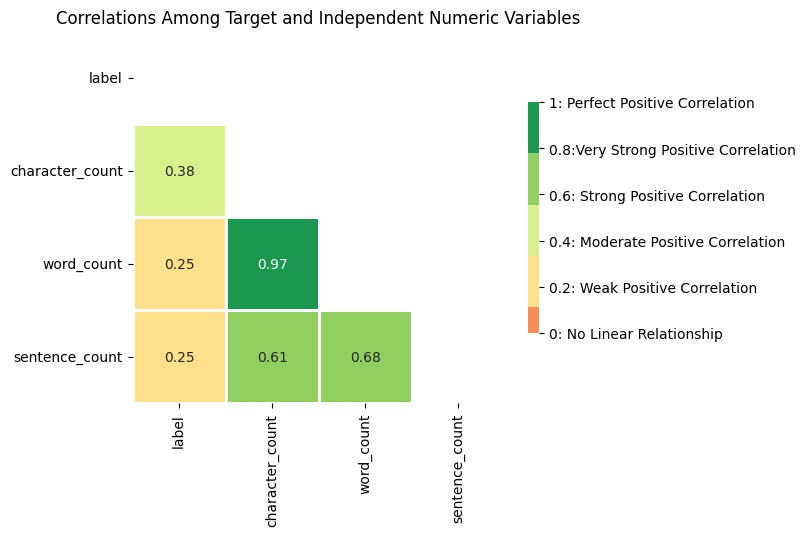

In [23]:
# Create correlation matrix round to 2 decimal places
corr_matrix = df_corr.corr().round(2)

# Generate a mask to the upper triangle of the matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(6, 6))

# Define the colormap for the five different correlation ranges
cmap = sns.color_palette(['#d73027', '#fc8d59', '#fee08b', '#d9ef8b', '#91cf60', '#1a9850'])

# Define the bins for the colormap
norm = plt.Normalize(vmin=0, vmax=1)

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, center=0.5,
                 square=True, linewidths=0.8, cbar_kws={"shrink": .5, 'ticks':[0, 0.2, 0.4, 0.6, 0.8, 1]}, annot=True, norm=norm)

# Custom colorbar labels
colorbar = ax.collections[0].colorbar
colorbar.set_ticklabels(['0: No Linear Relationship', '0.2: Weak Positive Correlation', '0.4: Moderate Positive Correlation', '0.6: Strong Positive Correlation', '0.8:Very Strong Positive Correlation', '1: Perfect Positive Correlation'])

# Add title to the heatmap
plt.title('Correlations Among Target and Independent Numeric Variables')

# Show the plot
plt.show()


##### 🔍 Observations

**Correlation between predictors and target variable**: These correlations show that messages with more characters, words and sentences are somewhat more likely to be spam.

**Correlation between predictors (Multicollinearity Analysis):**`character_count` and `word_count`have very strong correlation suggesting redundancy (both features provide similar information). Including both could cause issues related to multicollinearity.



#####💡Recommendations

* We might want to exclude the feature `word_count`; it has high multicollinearity with `character_count` which has slightly higher correlation with the label, making it more informative than `word_count`.
* Using `character_count` and `sentence_count `as input features can help us to classify messages as ham or spam.

## 3.2 Categorical Features

### 3.2.1 Examining Target Distribution: Checking for Class Imbalance

<font color = "4d5aa6">Visualizing the target variable distribution before implementing classification algorithms helps **identify class imbalance**, which can significantly impact model performance and decision-making.</font>

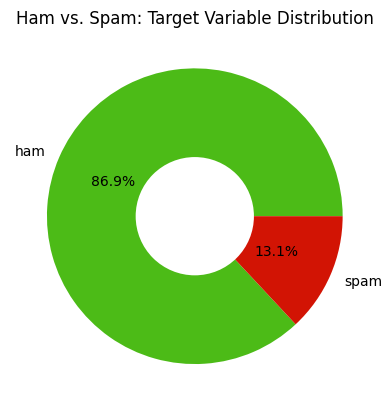

,label,count
0,ham,2871
1,spam,431


In [24]:
# Create a pie plot
colors = ['#4Cbb17', '#D21404']
plt.pie(df['label'].value_counts(), labels=df['label'].value_counts().index, autopct='%1.1f%%', colors=colors)
centre_circle = plt.Circle((0, 0), 0.4, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Ham vs. Spam: Target Variable Distribution')
plt.show()
# Show actual counts for each label
df['label'].value_counts().reset_index()

##### 🔍 Observations
A significant class imbalance between ham and spam can bias a machine learning model towards ham, resulting in poor spam detection. Our focus is on the minority class (spam), crucial for maintaining security and a positive user experience.

Cost-sensitive learning, useful for extreme imbalances (<5 % minority class), is also beneficial here. Adjusting class weights ensures attention to spam, but other methods like SMOTE or hybrid sampling might work equally well. The best approach depends on the dataset and model performance.

# 4. Data Preprocessing

In [25]:
df_p = df.copy()   # Make a copy of data to apply preprocessing

## 4.1 Label Encoding Target Variable

<font color = "4d5aa6">Machine Learning models require numerical input to effectively learn and make accurate classifications. The label encoder will encode 'ham' as 0 and 'spam' as 1.<font color = "4d5aa6">



In [26]:
# Init Label encoding object
le = LabelEncoder()

# Fit and transform labels
df_p['label'] = le.fit_transform(df_p['label'])

## 4.2 Text Processing

<font color = "4d5aa6">By applying preprocessing steps the model becomes more efficient and effective at detecting spam messages. We standardize the messages by eliminating irrelevant or redundant information helping the model to focus on the core content.</font>

✅ We define a function to implement the text preprocessing andfollows the sequence:
1. Tokenize the message into a list of individual words.
2. For each word in the list, a stemming(words are reduced to their root e.g. "running" becomes "run")is applied to the word if the word is alphanumeric(no punctuation or special characters) and if the lowercase of the word is not in the list of english stopwords (commonly used words in language like: "the", "is", "a" , and etc.)
3. The resulting list is concatenated into a single string and assigned to the variable `transformed_message`.



In [27]:
def text_preprocessing(text):
  '''
    Cleans text (removes non-alphanumeric characters, stopwords) and applies stemming to a given text.
    Args:
        text (str): The input text to be cleaned and stemmed.
    Returns:
        str: The cleaned and stemmed text.
  '''


  stop_words = set(stopwords.words('english'))
  stemmer = PorterStemmer()

  words = word_tokenize(text)
  cleaned_words = [stemmer.stem(word) for word in words if word.isalnum() and word.lower() not in stop_words]
  return ' '.join(cleaned_words)

In [28]:
df_p['transformed_message'] = df_p['message'].apply(text_preprocessing)

## 4.3 EDA: Preprocessed Data

### 4.3.1 Identifying Frequent Ham Words

In [29]:
# Create a dataframe that only shows ham messages
df_ham = df_p[df_p['label'] == 0]

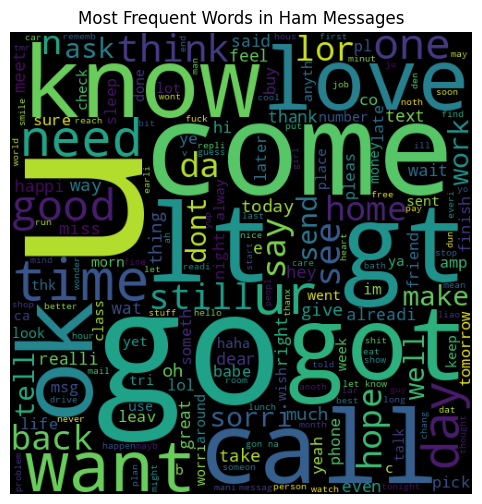

In [30]:
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'black')
ham_wc = wc.generate(df_ham['transformed_message'].str.cat(sep = ' '))
plt.figure(figsize = (10, 6))
plt.imshow(ham_wc)
plt.axis('off')
plt.title('Most Frequent Words in Ham Messages')
plt.show()

In [31]:
## Create a dataframe that showcases most frequent occuring words in ham messages

word_cnts = Counter()
for message in df_ham['transformed_message']:
  words = message.split()
  word_cnts.update(words)

ham_word_cnts = pd.DataFrame.from_dict(word_cnts, orient='index').reset_index()
ham_word_cnts.columns = ['word', 'count']

# Sort the DataFrame by word count in descending order
ham_word_cnts = ham_word_cnts.sort_values(by='count', ascending=False)

ham_word_cnts.head(10)

,word,count
20,u,560
0,go,260
132,get,214
222,gt,184
221,lt,183
298,come,176
89,2,173
134,know,163
16,ok,155
37,like,153


### 4.3.2 Identifying Frequent Spam Words

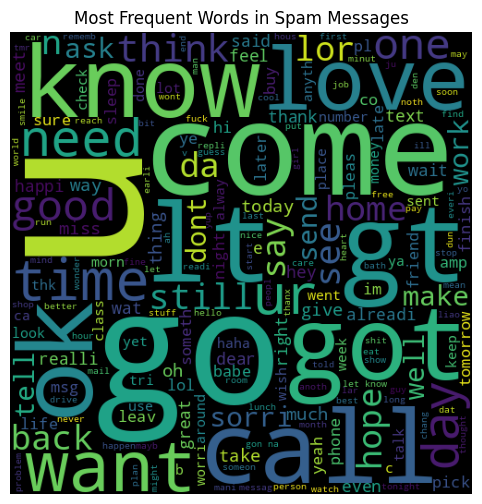

In [32]:
# Create a dataframe that only shows spam messages
df_spam = df_p[df_p['label'] == 1]

wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color = 'black')
spam_wc = wc.generate(df_spam['transformed_message'].str.cat(sep = ' '))
plt.figure(figsize = (10, 6))
plt.imshow(ham_wc)
plt.axis('off')
plt.title('Most Frequent Words in Spam Messages')
plt.show()

In [33]:
## Create a dataframe that showcases most frequent occuring words in spam messages

word_cnts = Counter()
for message in df_spam['transformed_message']:
  words = message.split()
  word_cnts.update(words)

spam_word_cnts = pd.DataFrame.from_dict(word_cnts, orient='index').reset_index()
spam_word_cnts.columns = ['word', 'count']

# Sort the DataFrame by word count in descending order
spam_word_cnts = spam_word_cnts.sort_values(by='count', ascending=False)

spam_word_cnts.head(10)

,word,count
48,call,201
0,free,130
2,2,108
18,txt,107
104,ur,90
58,u,90
13,text,76
55,mobil,70
79,4,68
288,stop,64


## 4.4 Feature Engineering

### 4.4.1 Feature Extraction with TF-IDF

We will initialize a TF-IDF vectorizer, selecting only the top 3000 words based on their TF-IDF scores. This approach reduces the dimensionality of the data, making the model more efficient to train and less prone to overfitting.

Transforming the text messages into numerical vectors generates a format that machine learning models can interpret and utilize effectively. The resulting X represents the feature matrix, while y represents the target variable.

In [34]:
# Initialize a TF-IDF vectorizer with a maximum of 3000 features
tfidf = TfidfVectorizer(max_features=3000)

# Create Feature and Target arrays
tfidf_features = tfidf.fit_transform(df_p['transformed_message']).toarray()
X = tfidf_features
y = df_p['label'].values

In [35]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

##### 🔍 Observations

Each element of the vector represents a specific word's weighted score for that message. These weights are continuous ranging between 0 and 1. We see that X is sparse (features many zeroes).

# 5. Model Building

## 5.1 Split data into Train and Test Sets

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 5.2 Model Selection

For our spam detection use case, selecting the appropriate model involves a comprehensive evaluation of various performance metrics to ensure it meets the task's specific demands. Given the inherent class imbalance in spam datasets—where legitimate messages (ham) significantly outnumber spam messages—our prioritization extends beyond simple accuracy.

<u>Key Performance Metrics:</u>

**Spam Recall**: To minimize false negatives, high recall for spam is vital. Missing a spam message can have varying levels of impact, from a minor inconvenience to severe security risks.

**Spam Precision**: While high recall is essential, spam precision is also evaluated to prevent the inadvertent flagging of legitimate messages as spam (false positives). False positives can result in the loss of important communications and lead to user frustration.

**F1-Score for Spam**: The F1-score, which provides a balanced measure of precision and recall, is used to gauge the overall effectiveness of the model in identifying spam while maintaining a low rate of false alarms.

### 5.2.1 Baseline Models

#### Gaussian Naive Bayes Classifier

Gaussian Naive Bayes Classification report:

              precision    recall  f1-score   support

         ham       0.97      0.89      0.93       575
        spam       0.52      0.81      0.63        86

    accuracy                           0.88       661
   macro avg       0.74      0.85      0.78       661
weighted avg       0.91      0.88      0.89       661



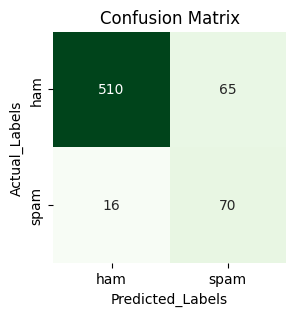

In [37]:
gnb = GaussianNB()
# Train model
gnb.fit(X_train, y_train)
# Make predictions
y_pred = gnb.predict(X_test)

print(f'Gaussian Naive Bayes Classification report:\n')
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'],cbar=False) # format=decimal
plt.xlabel('Predicted_Labels'),
plt.ylabel('Actual_Labels')
plt.title('Confusion Matrix')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


- TN = 510 : Out of all the actual ham messages, the model flagged 510 correctly as ham.
- FP = 65 : The model misclassified 65 ham messages as spam.
- <font color = firebrick> FN = 16 : The model misclassified 10 spam messages as ham.</font>
- TN : Out of all the actual spam messages, the model flagged 70 correctly as spam.

**Our goal is to reduce the False Negatives thereby increasing the Recall for Spam (models ability to correctly identify all instances of the spam class).** To balance the model performance we should also seek to reduce the False Positives which in turn will increase the Precision for Spam (the accuracy of positive predictions).

#### Multinomial Naive Bayes Classifier

Multinomial Naive Bayes : Classification report:

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       575
        spam       1.00      0.71      0.83        86

    accuracy                           0.96       661
   macro avg       0.98      0.85      0.90       661
weighted avg       0.96      0.96      0.96       661



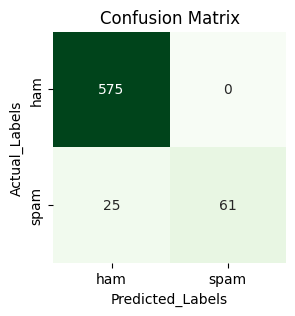

In [38]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

print(f'Multinomial Naive Bayes : Classification report:\n')
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'],cbar=False) # format=decimal
plt.xlabel('Predicted_Labels'),
plt.ylabel('Actual_Labels')
plt.title('Confusion Matrix')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

#### Bernoulli Naive Bayes Classifier


Bernoulli Naive Bayes: Classification report:

              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       575
        spam       1.00      0.81      0.90        86

    accuracy                           0.98       661
   macro avg       0.99      0.91      0.94       661
weighted avg       0.98      0.98      0.97       661



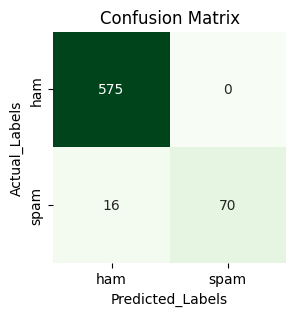

In [39]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
y_pred = bnb.predict(X_test)

print(f'Bernoulli Naive Bayes: Classification report:\n')
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'],cbar=False) # format=decimal
plt.xlabel('Predicted_Labels'),
plt.ylabel('Actual_Labels')
plt.title('Confusion Matrix')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

- There were 0 misclassification of ham messages.
- However, we have not managed to increase the amount of misclassified spam messages.

##### 🔍 Observations

Among the Naive Bayes classifiers employed for spam detection, the **BernoulliNB classifier** stands out with superior F1-scores. It excels in precision, avoiding any misclassification of spam messages. Moreover, it has the highest recall, correctly identifying 88% of actual spam messages. The **BernoulliNB classifier** outperforms others due to its proficiency in dealing with sparse data, its reduced sensitivity to class imbalance, and its compatibility with our binary-like tf-idf vectors (mostly zeros). While MultinomialNB performed adequately, it is better suited for actual integer counts rather than tf-idf weighted frequencies. On the other hand, GaussianNB struggled with sparse data due to its assumptions of normality and continuous feature handling.

#### Optimizing the Bernoulli classifier

We can adjust the classification threshold (default is 0.5). By lowering it, the model becomes more sensitive to the minority positive class (spam). This can help capture more spam instances, thereby improving Recall, but it may also lead to a higher false positive rate, degrading the Precision.

In [40]:
# Fit the model
bnb = BernoulliNB()
bnb.fit(X_train, y_train)

# Predict probabilities
y_prob = bnb.predict_proba(X_test)

# Adjust threshold
threshold = 0.2
y_pred = np.where(y_prob[:, 1] > threshold, 1, 0)

print(f'Bernoulli Naive Bayes(adjusted classification threshold) Classification report:\n')
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))

Bernoulli Naive Bayes(adjusted classification threshold) Classification report:

              precision    recall  f1-score   support

         ham       0.97      1.00      0.99       575
        spam       0.99      0.81      0.89        86

    accuracy                           0.97       661
   macro avg       0.98      0.91      0.94       661
weighted avg       0.97      0.97      0.97       661



### 5.2.2 Comparing different classifiers

We evaluate various classification models against Bernoulli Naive Bayes to determine the most effective model for spam detection. To address the class imbalance issue, we utilize class_weight='balanced' for all models except Bernoulli Naive Bayes and KNeighbors classifiers. This approach aims to improve recall_spam by assigning equal weight to both ham and spam classes during training, thereby minimizing the occurrence of False Negatives. Model performance is evaluated using recall_spam, precision_spam, f1_score_spam, and accuracy metrics.

In [41]:
def classifier_comparison_report(X_trn, X_tst, y_trn, y_tst):
  results = []
  classifiers = {
      'Logistic Regression': LogisticRegression(solver='liblinear', penalty='l1', class_weight='balanced'),
      'Support Vector Machine Classifier': SVC(kernel='sigmoid', gamma=1.0, class_weight='balanced'),
      'Bernoulli Naive Bayes': BernoulliNB(),
      'Decision Tree Classifier': DecisionTreeClassifier(max_depth=5, class_weight='balanced'),
      'KNN Classifier': KNeighborsClassifier()
  }

  for name, clf in classifiers.items():
      clf.fit(X_train, y_train)
      y_pred = clf.predict(X_test)

      accuracy = round(accuracy_score(y_test, y_pred), 2)
      report = classification_report(y_test, y_pred, target_names=['ham', 'spam'], output_dict=True)

      precision_spam = round(report['spam']['precision'], 2)
      recall_spam = round(report['spam']['recall'], 2)
      f1_score_spam = round(report['spam']['f1-score'], 2)

      # Append the result to the list
      results.append({
          'classifier': name,
          'recall_spam': recall_spam,
          'precision_spam': precision_spam,
          'f1_score_spam': f1_score_spam,
          'accuracy': accuracy,
      })

  # Create a DataFrame from the results
  results_df = pd.DataFrame(results)

  # Display the results
  return results_df

In [42]:
classifier_comparison_report(X_train, X_test, y_train, y_test)

,classifier,recall_spam,precision_spam,f1_score_spam,accuracy
0,Logistic Regression,0.84,0.87,0.85,0.96
1,Support Vector Machine Classifier,0.87,0.95,0.91,0.98
2,Bernoulli Naive Bayes,0.81,1.00,0.90,0.98
3,Decision Tree Classifier,0.76,0.66,0.70,0.92
4,KNN Classifier,0.22,1.00,0.36,0.90


Support Vector Machine Classifier yields the best results.

#### Handle Class Imbalance with 'class_weight' parameter

Support Vector Machine Classifier: Classification report:

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       575
        spam       0.95      0.87      0.91        86

    accuracy                           0.98       661
   macro avg       0.97      0.93      0.95       661
weighted avg       0.98      0.98      0.98       661



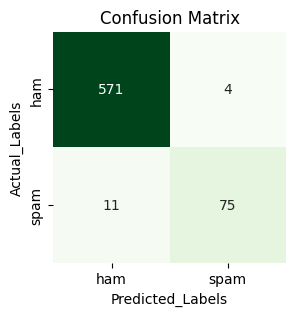

In [43]:
svc = SVC(kernel='sigmoid', gamma=1.0, class_weight='balanced')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print(f'Support Vector Machine Classifier: Classification report:\n')
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'],cbar=False) # format=decimal
plt.xlabel('Predicted_Labels'),
plt.ylabel('Actual_Labels')
plt.title('Confusion Matrix')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

##### 🔍 Observations
The **Support Vector Machine Classifier (SVC)** emerges as the optimal choice for optimizing Recall while balancing overall performance. Implementing the `class_weight` parameter significantly enhanced the recall for spam across various classifiers, notably for Logistic Regression, Support Vector Machine, and Decision Tree classifiers. This adjustment captures more spam but, in some cases, sacrifices precision, resulting in a higher number of false positives. Despite these trade-offs, the overall accuracy remains quite high for most of the classifiers.


## 5.3 Model Optimization

###  5.3.1 Include more Features and Compare different Classifiers

We include the features `character_count` and `sentence_count` in the feature set input to the classifiers. As noted in our Correlation Analysis section, these features may be potentially helpful for predicting spam. To ensure consistency, we apply MinMaxScaling, which scales the new features to the range of 0 to 1, aligning them with the tfidf_features.

In [44]:
# Vectorize the text data to get TF-IDF features
tfidf = TfidfVectorizer(max_features=3000)
tfidf_features = tfidf.fit_transform(df_p['transformed_message']).toarray()


additional_features = df_p[['character_count', 'sentence_count']].values
# Scale additional features
additional_features = MinMaxScaler().fit_transform(additional_features)
# Combine TF-IDF features with the additional features
combined_features = np.hstack((tfidf_features, additional_features))

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_features, df_p['label'].values, test_size=0.2, random_state=42)

In [45]:
classifier_comparison_report(X_train, X_test, y_train, y_test)

,classifier,recall_spam,precision_spam,f1_score_spam,accuracy
0,Logistic Regression,0.91,0.76,0.83,0.95
1,Support Vector Machine Classifier,0.94,0.89,0.92,0.98
2,Bernoulli Naive Bayes,0.87,1.00,0.93,0.98
3,Decision Tree Classifier,0.86,0.54,0.67,0.89
4,KNN Classifier,0.19,1.00,0.31,0.89


##### 🔍 Observations
SVC is still the optimal classifier and by adding the features we managed to further improve the model performance.

## Bayesian Optimization : Hyperparameter tuning

In [46]:
import logging

def objective(trial):
    # Hyperparameter search space
    param = {
        'C': trial.suggest_float('C', 1e-5, 1e2, log=True),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'degree': trial.suggest_int('degree', 2, 5),
        'class_weight': trial.suggest_categorical('class_weight',[None, 'balanced']) # Changed 'None' to None
    }

    model = SVC(**param, random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate f1_score for the positive class and store it in 'score'
    score = f1_score(y_test, y_pred, pos_label=1)
    #recall = recall_score(y_test, y_pred, pos_label=1)

    return score # Return the calculated score

# Set logging level to WARNING to suppress trial logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize(objective, n_trials=50)

In [47]:
print(f'Best parameters: {study.best_params}')
print(f'Best recall: {study.best_value}')

Best parameters: {'C': 3.4757882127084394, 'kernel': 'linear', 'gamma': 'scale', 'degree': 5, 'class_weight': None}
Best recall: 0.9585798816568047


Support Vector Machine Classifier: Classification report:

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       575
        spam       0.98      0.94      0.96        86

    accuracy                           0.99       661
   macro avg       0.98      0.97      0.98       661
weighted avg       0.99      0.99      0.99       661



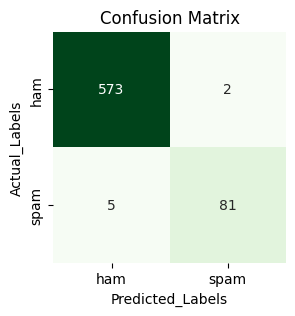

In [48]:
model = SVC(**study.best_params, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

print(f'Support Vector Machine Classifier: Classification report:\n')
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'],cbar=False) # format=decimal
plt.xlabel('Predicted_Labels'),
plt.ylabel('Actual_Labels')
plt.title('Confusion Matrix')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


##### 🔍 Observations

The results indicate that the SVM classifier performs exceptionally well, with high precision, recall, and F1-scores for both ham and spam. The accuracy is 99%, and the confusion matrix shows minimal misclassifications compared to the baseline models: Only 2 ham emails were incorrectly classified as spam and 5 spam emails were incorrectly classified as ham.

This high level of performance suggests that the classifier is highly effective at distinguishing between ham and spam, making it a reliable choice for applications requiring accurate email classification, such as spam detection systems.